In [10]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models


In [11]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

train_dir = "dataset/train"
test_dir = "dataset/test"


In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of training data will be used for validation
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 1441 images belonging to 2 classes.
Found 359 images belonging to 2 classes.
Found 104 images belonging to 2 classes.


In [13]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/20


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6173 - loss: 0.6594 - val_accuracy: 0.6546 - val_loss: 0.6450
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 346s 8s/step - accuracy: 0.6593 - loss: 0.6444 - val_accuracy: 0.6546 - val_loss: 0.6446
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6360 - loss: 0.6601 - val_accuracy: 0.6546 - val_loss: 0.6513
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6578 - loss: 0.6445 - val_accuracy: 0.6546 - val_loss: 0.6507
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6609 - loss: 0.6483 - val_accuracy: 0.6546 - val_loss: 0.6456
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6453 - loss: 0.6549 - val_accuracy: 0.6546 - val_loss: 0.6446
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6313 - loss: 0.6648 - val_accuracy: 0.6546 - val_loss: 0.6446
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6738 - loss: 0.6342 - val_accuracy: 0.6546 - val_loss: 0.6484
E

In [17]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Re-compile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.6450 - loss: 0.6543 - val_accuracy: 0.6546 - val_loss: 0.6466
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step - accuracy: 0.7836 - loss: 0.4906 - val_accuracy: 0.6546 - val_loss: 0.6513
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 274s 6s/step - accuracy: 0.8345 - loss: 0.3877 - val_accuracy: 0.6546 - val_loss: 0.6479
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 309s 7s/step - accuracy: 0.9164 - loss: 0.2854 - val_accuracy: 0.6546 - val_loss: 0.6423
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 374s 8s/step - accuracy: 0.9267 - loss: 0.2656 - val_accuracy: 0.6546 - val_loss: 0.6545
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - accuracy: 0.9222 - loss: 0.2270 - val_accuracy: 0.5822 - val_loss: 0.6611
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.9371 - loss: 0.1938 - val_accuracy: 0.6797 - val_loss: 0.4662
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.9365 - loss: 0.1845 - val_accuracy: 0.6490 - v

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {test_accuracy*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 918ms/step - accuracy: 0.3958 - loss: 0.7056
✅ Final Test Accuracy: 47.12%


In [20]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)

# Fine-tune the model for more epochs
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Increase this number for more training
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.9457 - loss: 0.1622 - val_accuracy: 0.6267 - val_loss: 0.6783
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.9406 - loss: 0.1548 - val_accuracy: 0.6462 - val_loss: 0.6784
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 279s 6s/step - accuracy: 0.9485 - loss: 0.1432 - val_accuracy: 0.6574 - val_loss: 0.6203
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.9529 - loss: 0.1330 - val_accuracy: 0.6546 - val_loss: 0.6505
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - accuracy: 0.9578 - loss: 0.1180 - val_accuracy: 0.6518 - val_loss: 0.7111
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 350s 8s/step - accuracy: 0.9544 - loss: 0.1156 - val_accuracy: 0.6602 - val_loss: 0.7418
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 235s 5s/step - accuracy: 0.9677 - loss: 0.0997 - val_accuracy: 0.6713 - val_loss: 0.6314
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - accuracy: 0.9696 - loss: 0.0814 - val_accuracy: 0.7187 - v

In [23]:
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

model.save("xray_model_pneumonia_vs_normal.h5")


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 806ms/step - accuracy: 0.9454 - loss: 0.1803



Test Accuracy: 95.19%


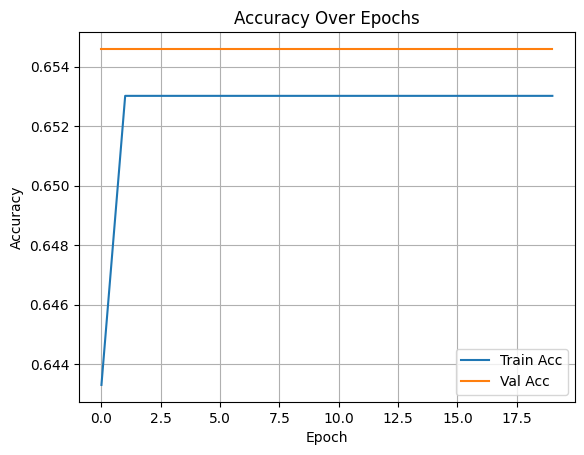

In [24]:
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
